##  1. Откроем файл с данными и изучим общую информацию

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.1. Импорт библиотек pandas, numpy, datetime, matplotlib.pyplot, seaborn

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
from matplotlib import pyplot as plt
from scipy import stats as st
import seaborn as sb
import math as mth
from plotly import graph_objects as go
pd.set_option('display.max_columns', None) #настройка, чтобы pandas не урезал столбцы

### 1.2. Загрузим данные из CSV-файла, в качестве разделителя знак табуляции \t

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Data/logs_exp.csv', sep='\t')

### 1.3. Изучим данные в датафреме data

In [4]:
display(data.head(10))
data.info();

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


## 2. Предобработка данных

### 2.1. Заменим названия столбцов на более удобные (переименуем столбцы)

In [5]:
data = data.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'user_id',
                            'EventTimestamp': 'date_time', 'ExpId':'group'})

### 2.2. Заменим названия групп 246 на А1, 247 на А2 и 248 на В

In [6]:
data = data.apply(lambda x:x.replace({246:'A1',247:'A2',248:'B'},regex=True))

### 2.3. Проверим пропуски, дубликаты и типы данных

In [7]:
data['date_time'] = pd.to_datetime(data['date_time'], unit='s') # преобразование данных о времени

#### 2.3.1. Проверим датафрем data на пропуски и дубликаты

In [8]:
print(data.isna().sum()); # проверка на пропуски

event_name    0
user_id       0
date_time     0
group         0
dtype: int64


Пропуски не обнаружены

#### 2.3.2. Проверим датафрем data на дубликаты

In [9]:
print(data.duplicated().sum())

413


Размер датафрема 244126. Было выявлено 413 полных дубликатов, что составляет лишь 0.17% от всего датафрема. Поэтому дубликаты можем удалить.

In [10]:
data = data.drop_duplicates(keep='first') # удаляем найденные дубликаты
data = data.reset_index(drop=True) #выравниваем индексы

In [11]:
print(data.duplicated().sum()) #проверка

0


### 2.4. Добавим столбец даты и времени, а также отдельный столбец дат.

In [12]:
data['date'] = data['date_time'].dt.floor('1D')

In [13]:
# выведем датафрем и информиацию о нем после преобразований
display(data.head(10))
data.info()

,event_name,user_id,date_time,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,A1,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,A1,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,B,2019-07-25
5,CartScreenAppear,6217807653094995999,2019-07-25 11:48:43,B,2019-07-25
6,OffersScreenAppear,8351860793733343758,2019-07-25 14:50:42,A1,2019-07-25
7,MainScreenAppear,5682100281902512875,2019-07-25 20:14:37,A1,2019-07-25
8,MainScreenAppear,1850981295691852772,2019-07-25 20:31:42,A2,2019-07-25
9,MainScreenAppear,5407636962369102641,2019-07-26 03:35:12,A1,2019-07-26


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   date_time   243713 non-null  datetime64[ns]
 3   group       243713 non-null  object        
 4   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 9.3+ MB


## 3. Изучим и проверим данные

### 3.1. Определим, сколько всего событий в датафреме

In [14]:
print('Количество событий в датафреме:', data['event_name'].count())

Количество событий в датафреме: 243713


### 3.2. Определим, сколько всего пользователей в датафреме

In [15]:
print('Количество уникальных пользователей:', data['user_id'].nunique())

Количество уникальных пользователей: 7551


### 3.3. Определим, сколько в среднем событий приходится на пользователя

In [16]:
print('Среднее количество событий на пользователя:', round((data['event_name'].count() / data['user_id'].nunique()), 0))

Среднее количество событий на пользователя: 32.0


### 3.4. Найдем максимальную и минимальную дату. Построим гистограмму по дате и времени. Определим, с какого момента данные полные и отбросим более старые.

#### 3.4.1. Найдем максимальную и минимальную даты

In [17]:
date_min = data['date_time'].min()
date_max = data['date_time'].max()
print('Минимальная дата:', date_min)
print('Максимальная дата:', date_max)

Минимальная дата: 2019-07-25 04:43:36
Максимальная дата: 2019-08-07 21:15:17


#### 3.4.2. Построим гистограмму по дате и времени

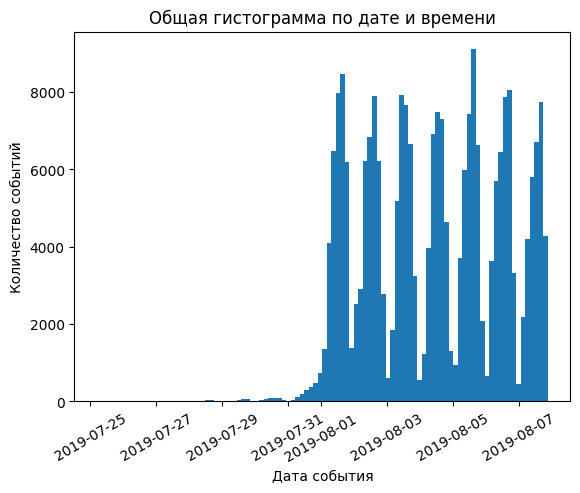

In [18]:
plt.hist(data['date_time'], bins=100)
plt.xticks(rotation = 30)
plt.title('Общая гистограмма по дате и времени')
plt.xlabel('Дата события')
plt.ylabel('Количество событий');

На гистограмме видно, что данные о событиях до 01 августа 2019 года практически отсутствуют. Таким образом, можем предположить, что для анализа следует использовать период **с 01.08.2019 по 07.08.2019**

### 3.5. Определим, много ли событий и пользователей было потеряно после  удаления старых данных.

In [19]:
date_to_cut = dt(2019, 8, 1)
data_sort = data.query('date_time >= @date_to_cut')

In [20]:
print('Количество событий после сортировки:', data_sort['event_name'].count())

Количество событий после сортировки: 240887


В датафреме после удаления дубликатов 243713 событий. Отбросив события раньше 01.08.2019 удалили 2826 событий, что составляет 1.16% от событий в датафреме. Поскольку процент удаленных событий менее 10%, его можно смело не учитывать в дальнейшем анализе.
Таким образом, будем изучать данные за период с **01.08.2019 по 07.08.2019**

In [21]:
print('Количество уникальных пользователей после сортировки:', data_sort['user_id'].nunique())

Количество уникальных пользователей после сортировки: 7534


In [22]:
print('Процент удаленных уникальных пользователей:', round((1-data_sort['user_id'].nunique() /
                                                 data ['user_id'].nunique())*100, 2))

Процент удаленных уникальных пользователей: 0.23


In [23]:
print('Процент удаленных событий:', round((1-data_sort['event_name'].count() /
                                           data['event_name'].count())*100, 2))

Процент удаленных событий: 1.16


Процент удаленных уникальных ользователей составил 0,23%, а процент удаленных событий 1,16%. Эти изменения меньше 10%, поэтому для анализа будем использовать временной промежуток с 01.08.2019 по 07.08.2019.

### 3.6. Проверим, есть ли пользователи из всех трёх экспериментальных групп.

In [24]:
# Проверим, сколько пользователей попали одновременно в три группы:
triple_users = data_sort.groupby('user_id').agg({'group' : 'nunique'}).query('group>1').count()

In [25]:
print('Количество пользователей, одновременно попавших в три группы:', triple_users);

Количество пользователей, одновременно попавших в три группы: group    0
dtype: int64


Пользователи, попавшие в три группы теста отсутствуют.

## 4. Изучим воронку событий

### 4.1. Посмотрим, какие события есть в логах и как часто они встречаются. Отсортируем события по частоте.

In [26]:
events_count = data_sort.groupby('event_name').agg({'user_id': 'count'}).sort_values('user_id', ascending=False)
print(events_count)

                         user_id
event_name                      
MainScreenAppear          117328
OffersScreenAppear         46333
CartScreenAppear           42303
PaymentScreenSuccessful    33918
Tutorial                    1005


Видов событий всего 5:
- MainScreenAppear (появление главного экрана) - событие встречается чаще всего,
- OffersScreenAppear (появление экрана предложений),
- CartScreenAppear (появление экрана корзины),
- PaymentScreenSuccessful (экран успешной оплаты),
- Tutorial (руководство) - событие встречается реже всего.

### 4.2. Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [27]:
users_count = data_sort.groupby('event_name').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)
print(users_count)

                         user_id
event_name                      
MainScreenAppear            7419
OffersScreenAppear          4593
CartScreenAppear            3734
PaymentScreenSuccessful     3539
Tutorial                     840


In [28]:
# Посчитаем долю пользователей, которые хоть раз совершали событие
users_count / len(data_sort['user_id'].unique())*100

,user_id
event_name,
MainScreenAppear,98.473586
OffersScreenAppear,60.963632
CartScreenAppear,49.561986
PaymentScreenSuccessful,46.973719
Tutorial,11.149456


Около 1,5% пользователей миновали главный экран, потому что могли попасть на страницы товаров по прямой ссылке через уведомления, почтовую рассылку или результаты поисковиков.

### 4.3. Предположим, в каком порядке происходят события.


Предполагаемый порядок действий:
 - Tutorial (руководство). Использование приложение начинается с изучения руководства пользователя. Но лишь 11% пользователей не пропускают это шаг.
 - MainScreenAppear (главный экран). Далее пользователь попадает на главный экран. Это 98.47% пользователей. Скорее всего, чтобы использовать приложение дальше, без этого шага не обойтись.
 - OffersScreenAppear (предложение). Экран "предложение" видят около 60.96% пользователей. После главного экрана "отваливается" около 38% пользователей. Это довольно много. На мой взгляд, стоит обратить внимание на этот момент.
 - CartScreenAppear (добавление товара в корзину). Около 50% пользователей, вошедших в воронку, добавляют товар в корзину.
 - PaymentScreenSuccessful (успешная оплата). Около 47% совершили оплату заказа.

Для использования приложения и совершения покупок не обязательно выполнять все шаги последовательно. С уверенностью можно сказать, что Tutorial можно исключить (всего 11% пользователей совершают данное действие).

In [29]:
df = data_sort.query('event_name != "Tutorial"') #исключаем событие Tutorial

### 4.4. По воронке событий посчитайем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

In [30]:
users_count_df = df.groupby('event_name').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)

In [31]:
users_count_df['prev_step'] = users_count_df['user_id'].shift(periods=1, fill_value=0)
users_count_df['share'] = users_count_df['user_id'] / users_count_df['prev_step']

print(users_count_df)

                         user_id  prev_step     share
event_name                                           
MainScreenAppear            7419          0       inf
OffersScreenAppear          4593       7419  0.619086
CartScreenAppear            3734       4593  0.812976
PaymentScreenSuccessful     3539       3734  0.947777


### 4.5. Определим, на каком шаге теряете больше всего пользователей.

На шаге OffersScreenAppear отваливается больше всего пользователей (около 38%)

### 4.6. Определим, какая доля пользователей доходит от первого события до оплаты.

На первом шаге 7419  пользователей. До оплаты дошло 3539 пользователей. Доля  пользователей, которые доходят с первого шага до оплаты составляет 47.7 %

## 5. Изучим результаты эксперимента

### 5.1. Определим, сколько пользователей в каждой экспериментальной группе.

In [32]:
df_user_counts = df.groupby('group').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)

print(df_user_counts)

       user_id
group         
B         2535
A2        2512
A1        2483


Количесво пользователей в группе А1 отличается от группы А2 на 1,15%, а группы А2 и В на 0,9%

In [33]:
# добавим переменную, в которой сложим пользователей из А1 и А2. Она понадобится в дальнейшем.
df_user_countsA3 = df_user_counts.loc['A2', 'user_id'] + df_user_counts.loc['A1', 'user_id']
print(df_user_countsA3)

4995


### 5.2. Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

In [34]:
# Сформируем датафрем df_pivot_all, в котром отразим сколько раз было совершено каждое событие в каждой группе.
df_pivot_all = df.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='count')
df_pivot_all['A3'] = df_pivot_all['A1'] + df_pivot_all['A2']
print(df_pivot_all)

group                       A1     A2      B     A3
event_name                                         
CartScreenAppear         14690  12434  15179  27124
MainScreenAppear         37676  39090  40562  76766
OffersScreenAppear       14767  15179  16387  29946
PaymentScreenSuccessful  11852   9981  12085  21833


In [35]:
# Сформируем датафрем df_pivot_all_uniq, в котром отразим
#сколько раз было совершено каждое событие уникальными пользователями в каждой группе.

df_pivot_all_uniq = df.pivot_table(index='event_name', columns='group', values='user_id', aggfunc={'user_id': 'nunique'})
df_pivot_all_uniq['A3'] = df_pivot_all_uniq['A1'] + df_pivot_all_uniq['A2']
print(df_pivot_all_uniq)

group                      A1    A2     B    A3
event_name                                     
CartScreenAppear         1266  1238  1230  2504
MainScreenAppear         2450  2476  2493  4926
OffersScreenAppear       1542  1520  1531  3062
PaymentScreenSuccessful  1200  1158  1181  2358


In [36]:
fig = go.Figure()
fig.update_layout(title={'text': "Воронка событий"})

fig.add_trace(go.Funnel(
    name = 'A1',
    y = ["MainScreenAppear", "OffersScreenAppear", "CartScreenAppear", "PaymentScreenSuccessful"],
    x = [2450, 1542, 1266, 1200],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'A2',
    orientation = "h",
    y = ["MainScreenAppear", "OffersScreenAppear", "CartScreenAppear", "PaymentScreenSuccessful"],
    x = [2476, 1520, 1238, 1158],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y = ["MainScreenAppear", "OffersScreenAppear", "CartScreenAppear", "PaymentScreenSuccessful"],
    x = [2493, 1531, 1230, 1181],
    textposition = "outside",
    textinfo = "value+percent total"))

fig.show()

#### 5.2.1. Сформируем функцию для проверки гипетез

1.   Нулевая гипотеза: доли равны; Альтернативная гипотеза: между долями есть разница
2.  Уровень статистической значимости alpha = 0.05
3.  Будем проводить z-тест. Так как распределение статистики нормальное, вызовем метод cdf(). Саму статистику возьмём по модулю методом abs() — чтобы получить правильный результат независимо от её знака. Это возможно, потому что тест двусторонний.


In [37]:
#функция для проверки
def ztest(alpha, successes, trials):
    shidak = 1 - (1-alpha)**(1/16)

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < shidak:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [38]:
successes_A1_A2_msa = np.array([df_pivot_all_uniq.loc['MainScreenAppear', 'A1'],
                                df_pivot_all_uniq.loc['MainScreenAppear', 'A2']])
trials_A1_A2_msa = np.array([df_user_counts.loc['A1', 'user_id'],df_user_counts.loc['A2', 'user_id']])
ztest(0.05, successes_A1_A2_msa, trials_A1_A2_msa)

successes_A1_A2_osa = np.array([df_pivot_all_uniq.loc['OffersScreenAppear', 'A1'],
                             df_pivot_all_uniq.loc['OffersScreenAppear', 'A2']])
trials_A1_A2_osa = np.array([df_user_counts.loc['A1', 'user_id'],df_user_counts.loc['A2', 'user_id']])
ztest(0.05, successes_A1_A2_osa, trials_A1_A2_osa)

successes_A1_A2_csa = np.array([df_pivot_all_uniq.loc['CartScreenAppear', 'A1'],
                             df_pivot_all_uniq.loc['CartScreenAppear', 'A2']])
trials_A1_A2_csa = np.array([df_user_counts.loc['A1', 'user_id'],df_user_counts.loc['A2', 'user_id']])
ztest(0.05, successes_A1_A2_csa, trials_A1_A2_csa)

successes_A1_A2_pss = np.array([df_pivot_all_uniq.loc['PaymentScreenSuccessful', 'A1'],
                            df_pivot_all_uniq.loc['PaymentScreenSuccessful', 'A2']])
trials_A1_A2_pss = np.array([df_user_counts.loc['A1', 'user_id'],df_user_counts.loc['A2', 'user_id']])
ztest(0.05, successes_A1_A2_pss, trials_A1_A2_pss)

p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По итогам проверки принимаем нулевую гипотезу, т.е. разница между долями в группах А1 и А2 отсутствует, либо столь незначительна, что ее можно не учитывать. На мой взгляд, это означает, что разбивка по группам проведена корректно


### 5.3. Выберем самое популярное событие. Посчитайем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий.

#### 5.3.1. Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой контрольной группе. Посчитаем долю пользователей, совершивших это событие.

In [39]:
# определим самое популярное событие
most_popular_event = df['event_name'].value_counts().index[0]
print('Самое популярное событие:', most_popular_event)

Самое популярное событие: MainScreenAppear


In [40]:
# посчитаем число пользователей, совершивших это событие в каждой из контрольных групп
df_pivot = df.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='count'
                         ).query('event_name == @most_popular_event')
print(df_pivot)

group                A1     A2      B
event_name                           
MainScreenAppear  37676  39090  40562


In [41]:
# Посчитаем долю пользователей, совершивших это событие
shareA1 = df_pivot.loc['MainScreenAppear', 'A1'] / events_count.loc['MainScreenAppear', 'user_id'] * 100
shareA2 = df_pivot.loc['MainScreenAppear', 'A2'] / events_count.loc['MainScreenAppear', 'user_id'] * 100
shareB = df_pivot.loc['MainScreenAppear', 'B'] / events_count.loc['MainScreenAppear', 'user_id'] * 100

In [42]:
print('Доля пользователей, совершивших событие в А1:', round(shareA1, 2))
print('Доля пользователей, совершивших событие в А2:', round(shareA2, 2))
print('Доля пользователей, совершивших событие в В:', round(shareB, 2))

Доля пользователей, совершивших событие в А1: 32.11
Доля пользователей, совершивших событие в А2: 33.32
Доля пользователей, совершивших событие в В: 34.57


Доли пользователей, совершивших самое популярное событие MainScreenAppear, в группах А1, А2 и В примерно равны (в районе 32%).

#### 5.3.2. Проверим, будет ли отличие между группами статистически достоверным по всем событиям между группами А1 и В.

1. Нулевая гипотеза: доли равны, Альтернативная гипотеза: между долями есть разница
2. Уровень статистической значимости alpha = 0.05
3. Будем проводить z-тест. Так как распределение статистики нормальное, вызовем метод cdf(). Саму статистику возьмём по модулю методом abs() — чтобы получить правильный результат независимо от её знака. Это возможно, потому что тест двусторонний


In [43]:
successes_A1_B_msa = np.array([df_pivot_all_uniq.loc['MainScreenAppear', 'A1'],
                               df_pivot_all_uniq.loc['MainScreenAppear', 'B']])
trials_A1_B_msa = np.array([df_user_counts.loc['A1', 'user_id'],df_user_counts.loc['B', 'user_id']])
ztest(0.05, successes_A1_B_msa, trials_A1_B_msa)

successes_A1_B_osa = np.array([df_pivot_all_uniq.loc['OffersScreenAppear', 'A1'],
                               df_pivot_all_uniq.loc['OffersScreenAppear', 'B']])
trials_A1_B_osa = np.array([df_user_counts.loc['A1', 'user_id'],df_user_counts.loc['B', 'user_id']])
ztest(0.05, successes_A1_B_osa, trials_A1_B_osa)

successes_A1_B_csa = np.array([df_pivot_all_uniq.loc['CartScreenAppear', 'A1'],
                               df_pivot_all_uniq.loc['CartScreenAppear', 'B']])
trials_A1_B_csa = np.array([df_user_counts.loc['A1', 'user_id'],df_user_counts.loc['B', 'user_id']])
ztest(0.05, successes_A1_B_csa, trials_A1_B_csa)

successes_A1_B_pss = np.array([df_pivot_all_uniq.loc['PaymentScreenSuccessful', 'A1'],
                            df_pivot_all_uniq.loc['PaymentScreenSuccessful', 'B']])
trials_A1_B_pss = np.array([df_user_counts.loc['A1', 'user_id'],df_user_counts.loc['B', 'user_id']])
ztest(0.05, successes_A1_B_pss, trials_A1_B_pss)

p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### 5.3.3. Проверим, будет ли отличие между группами статистически достоверным по всем событиям между группами А2 и В.

1. Нулевая гипотеза: доли равны, Альтернативная гипотеза: между долями есть разница
2. Уровень статистической значимости alpha = 0.05
3. Будем проводить z-тест. Так как распределение статистики нормальное, вызовем метод cdf(). Саму статистику возьмём по модулю методом abs() — чтобы получить правильный результат независимо от её знака. Это возможно, потому что тест двусторонний

In [44]:
successes_A2_B_msa = np.array([df_pivot_all_uniq.loc['MainScreenAppear', 'A2'],
                               df_pivot_all_uniq.loc['MainScreenAppear', 'B']])
trials_A2_B_msa = np.array([df_user_counts.loc['A2', 'user_id'],df_user_counts.loc['B', 'user_id']])
ztest(0.05, successes_A2_B_msa, trials_A2_B_msa)

successes_A2_B_osa = np.array([df_pivot_all_uniq.loc['OffersScreenAppear', 'A2'],
                               df_pivot_all_uniq.loc['OffersScreenAppear', 'B']])
trials_A2_B_osa = np.array([df_user_counts.loc['A2', 'user_id'],df_user_counts.loc['B', 'user_id']])
ztest(0.05, successes_A2_B_osa, trials_A2_B_osa)

successes_A2_B_csa = np.array([df_pivot_all_uniq.loc['CartScreenAppear', 'A2'],
                               df_pivot_all_uniq.loc['CartScreenAppear', 'B']])
trials_A2_B_csa = np.array([df_user_counts.loc['A2', 'user_id'],df_user_counts.loc['B', 'user_id']])
ztest(0.05, successes_A2_B_csa, trials_A2_B_csa)

successes_A2_B_pss = np.array([df_pivot_all_uniq.loc['PaymentScreenSuccessful', 'A2'],
                            df_pivot_all_uniq.loc['PaymentScreenSuccessful', 'B']])
trials_A2_B_pss = np.array([df_user_counts.loc['A2', 'user_id'],df_user_counts.loc['B', 'user_id']])
ztest(0.05, successes_A2_B_pss, trials_A2_B_pss)

p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### 5.3.4. Проверим, будет ли отличие между группами статистически достоверным по всем событиям между группами А3 и В.

1. Нулевая гипотеза: доли равны, Альтернативная гипотеза: между долями есть разница
2. Уровень статистической значимости alpha = 0.05
3. Будем проводить z-тест. Так как распределение статистики нормальное, вызовем метод cdf(). Саму статистику возьмём по модулю методом abs() — чтобы получить правильный результат независимо от её знака. Это возможно, потому что тест двусторонний

In [45]:
successes_A3_B_msa = np.array([df_pivot_all_uniq.loc['MainScreenAppear', 'A3'],
                               df_pivot_all_uniq.loc['MainScreenAppear', 'B']])
trials_A3_B_msa = np.array([df_user_countsA3, df_user_counts.loc['B', 'user_id']])
ztest(0.05, successes_A3_B_msa, trials_A3_B_msa)

successes_A3_B_osa = np.array([df_pivot_all_uniq.loc['OffersScreenAppear', 'A3'],
                               df_pivot_all_uniq.loc['OffersScreenAppear', 'B']])
trials_A3_B_osa = np.array([df_user_countsA3,df_user_counts.loc['B', 'user_id']])
ztest(0.05, successes_A3_B_osa, trials_A3_B_osa)

successes_A3_B_csa = np.array([df_pivot_all_uniq.loc['CartScreenAppear', 'A3'],
                               df_pivot_all_uniq.loc['CartScreenAppear', 'B']])
trials_A3_B_csa = np.array([df_user_countsA3, df_user_counts.loc['B', 'user_id']])
ztest(0.05, successes_A3_B_csa, trials_A3_B_csa)

successes_A3_B_pss = np.array([df_pivot_all_uniq.loc['PaymentScreenSuccessful', 'A3'],
                            df_pivot_all_uniq.loc['PaymentScreenSuccessful', 'B']])
trials_A3_B_pss = np.array([df_user_countsA3, df_user_counts.loc['B', 'user_id']])
ztest(0.05, successes_A3_B_pss, trials_A3_B_pss)

p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Около 1,5% пользователей миновали главный экран. Причина может быть в том, что пользователи попадали на страницы товаров по прямой ссылке через уведомления, почтовую рассылку или результаты поисковиков. Это совсем небольшой процент пользователей, что говорит о редкости данного явления. 98,5% пользователей всеже попадают на главнй экран.
На следующем шаге конверсия ухудшается: почти 40% пользователей отваливаются на переходе к старнице предложения. Это довольно большое количество, поэто стоит обратить на это внимание и выявить причины (возможно, кнопка/ссылка для перехода к предложению не слишком заметна, и пользователи просто ее не видят).
Товары в корзину добавляют 81% от перешедшеих со страницы предложния пользователей (с предыдщуего шага) или около 50% всех пользователей приложения. Из добавивших товар в корзину, 94% пользователей успешно оплачивают его (около 47% от всех пользователей).
Мы видим, что около 80-90% пользователей, перешедших на странцу с предложением, оплачивают товар. Это отличный показатель.
Рекомендую обратить внимание на переход на страницу предложения, выявить причины низкой конверсии и разработать предложения по ее увеличению.

### 5.4. Выводы

Поскольку было проведено 20 сравнений, был применен метод Шидака. уровен значимости был расчитан по формуле shidak = 1 - (1-alpha)^(1/20), где alpha = 0.05.

Нулевая гипотеза звучала: доли равны.
Т.е. соотношения уникальных пользователей, совершивших то или иное событие в приложении, к общему числу уникальных пользователей приложения равны в группе А и группе В. Или другими словами изменение шрифтов не влияет на конверсию пользователей и она равна в группах А и В. Чем меньше p-значение, тем больше определенность в том, что нулевая гипотеза является ложной, и что мы нашли подлинный эффект.
По итогам теста мы принимаем нулевую гипотезу.
Получается, что измение шрифта не повлияет на конверсию пользователей (т.е. не ухудщит и не улучшит ее). В связи с этим, как я понимаю, изменять шрифты не нужно.


Сравнивая группы между собой, можно заметить, что статистически значимые различия наблюдаются по событиям OffersScreenAppear (т.е. экран предложения) и CartScreenAppear (т.е. добавление в корзину) при сравнении объединенной контрольной группы А3 и экспериментальной группы В.
Получается, что показатели объединенной контрольной группы выше, чем экспериментальной. Это говорит о том, что изменение шрифтов негативно сказывается на переходе на экран предложение и добавление товара в корзину.
На переход на главный экран и оплату шрифты не влияют.  
На мой взгляд, эксперимент стоит признать не удачным и не изменять шрифты. Однако стоит обратить внимание на причины большого оттока пользователей на шаге OffersScreenAppear (т.е. экран предложения). Судя по всему причина не в шрифтах.

